In [1]:
import numpy as np
import os
import cv2
import shutil
import random as rn
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
data_dir ="Med_list"

In [3]:
print(os.listdir(data_dir))

['Amoxycillin', 'Cetamol', 'Cetirizine', 'Cipro', 'Jiwanjal', 'SilverSulph', 'Vicks']


In [4]:
batch_size = 32
img_height = 350
img_width = 450

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.25,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2441 files belonging to 7 classes.
Using 1831 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.25,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2441 files belonging to 7 classes.
Using 610 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['Amoxycillin', 'Cetamol', 'Cetirizine', 'Cipro', 'Jiwanjal', 'SilverSulph', 'Vicks']


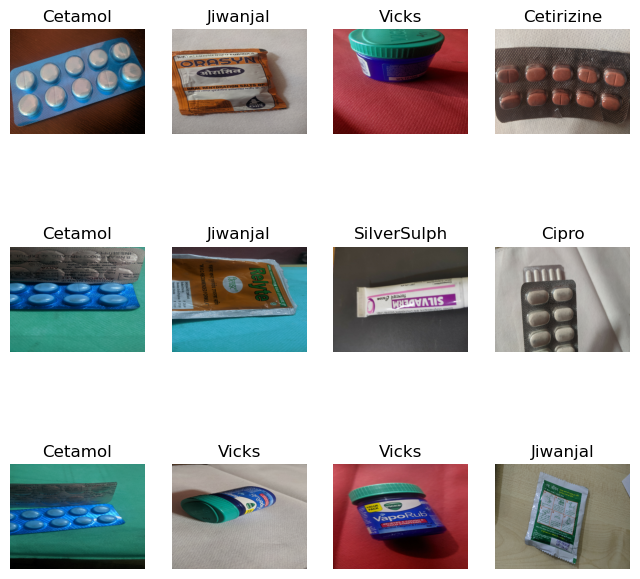

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 350, 450, 3)
(32,)


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
#pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.95166713


In [13]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1,fill_mode='reflect',),
    layers.experimental.preprocessing.RandomZoom([0.2,0.5]),
    layers.experimental.preprocessing.RandomWidth(0.3),
    layers.experimental.preprocessing.RandomHeight(0.2),
    layers.experimental.preprocessing.RandomContrast([0.1,0.5]),
    layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
    layers.experimental.preprocessing.RandomCrop(220,200),
  ]
)

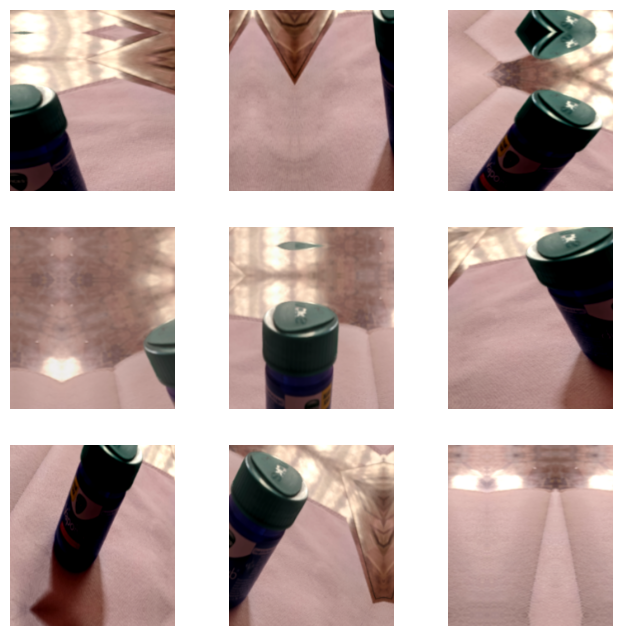

In [14]:
plt.figure(figsize=(8, 8))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images,training=True)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [15]:
num_classes = 7
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu',input_shape=(350,450,3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 220, 200, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 220, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 220, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 100, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 100, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 50, 32)       0         
 2D)                                                  

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
#Add Callbacks, e.g. ModelCheckpoints, earlystopping, csvlogger.
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

In [22]:
#ModelCheckpoint callback saves a model at some interval. 
filepath="S_Model/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5" #File name includes epoch and validation accuracy.

#Use Mode = max for accuracy and min for loss. 
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',validation_split=0.1, verbose=1, save_best_only=True, mode='max')

early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)
#This callback will stop the training when there is no improvement in 10

#CSVLogger logs epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('S_Model/logs/my_logs.csv', separator=',', append=False)

In [23]:
#Tensorboard callback
from tensorflow.keras.callbacks import TensorBoard
file_name = 'my_saved_modelmay21'  #Give unique name each time, otherwise results get concatenated
#Try running multiple times and see the output in tensorboard
#If file name is changed, you can select the specific model in TensorBoard

In [24]:
tensorboard = TensorBoard(log_dir="logs\\{}".format(file_name))

In [25]:
callbacks_list = [checkpoint,log_csv,[tensorboard]]

In [26]:
epochs=478
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks_list
)

Epoch 1/478


C:\Users\Lenovo\miniconda3\envs\tfenv\Lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


58/58 [==============================] - ETA: 0s - loss: 1.8064 - accuracy: 0.2835
Epoch 1: val_accuracy improved from -inf to 0.33607, saving model to S_Model\weights-improvement-01-0.34.hdf5
58/58 [==============================] - 86s 1s/step - loss: 1.8064 - accuracy: 0.2835 - val_loss: 1.6373 - val_accuracy: 0.3361
Epoch 2/478
58/58 [==============================] - ETA: 0s - loss: 1.6413 - accuracy: 0.3457
Epoch 2: val_accuracy improved from 0.33607 to 0.43770, saving model to S_Model\weights-improvement-02-0.44.hdf5
58/58 [==============================] - 73s 1s/step - loss: 1.6413 - accuracy: 0.3457 - val_loss: 1.3757 - val_accuracy: 0.4377
Epoch 3/478
58/58 [==============================] - ETA: 0s - loss: 1.4721 - accuracy: 0.4134
Epoch 3: val_accuracy improved from 0.43770 to 0.47541, saving model to S_Model\weights-improvement-03-0.48.hdf5
58/58 [==============================] - 68s 1s/step - loss: 1.4721 - accuracy: 0.4134 - val_loss: 1.3635 - val_accuracy: 0.4754
Epoc

Epoch 28/478
58/58 [==============================] - ETA: 0s - loss: 0.5336 - accuracy: 0.7963
Epoch 28: val_accuracy did not improve from 0.86230
58/58 [==============================] - 68s 1s/step - loss: 0.5336 - accuracy: 0.7963 - val_loss: 0.4194 - val_accuracy: 0.8475
Epoch 29/478
58/58 [==============================] - ETA: 0s - loss: 0.5625 - accuracy: 0.7870
Epoch 29: val_accuracy did not improve from 0.86230
58/58 [==============================] - 68s 1s/step - loss: 0.5625 - accuracy: 0.7870 - val_loss: 0.5114 - val_accuracy: 0.8131
Epoch 30/478
58/58 [==============================] - ETA: 0s - loss: 0.5339 - accuracy: 0.7936
Epoch 30: val_accuracy did not improve from 0.86230
58/58 [==============================] - 68s 1s/step - loss: 0.5339 - accuracy: 0.7936 - val_loss: 0.3985 - val_accuracy: 0.8574
Epoch 31/478
58/58 [==============================] - ETA: 0s - loss: 0.5810 - accuracy: 0.7843
Epoch 31: val_accuracy did not improve from 0.86230
58/58 [==============

58/58 [==============================] - 70s 1s/step - loss: 0.2730 - accuracy: 0.9022 - val_loss: 0.2298 - val_accuracy: 0.9164
Epoch 86/478
58/58 [==============================] - ETA: 0s - loss: 0.3315 - accuracy: 0.8782
Epoch 86: val_accuracy did not improve from 0.92951
58/58 [==============================] - 69s 1s/step - loss: 0.3315 - accuracy: 0.8782 - val_loss: 0.2545 - val_accuracy: 0.9230
Epoch 87/478
58/58 [==============================] - ETA: 0s - loss: 0.3052 - accuracy: 0.8968
Epoch 87: val_accuracy did not improve from 0.92951
58/58 [==============================] - 69s 1s/step - loss: 0.3052 - accuracy: 0.8968 - val_loss: 0.2343 - val_accuracy: 0.9131
Epoch 88/478
58/58 [==============================] - ETA: 0s - loss: 0.3207 - accuracy: 0.8864
Epoch 88: val_accuracy did not improve from 0.92951
58/58 [==============================] - 69s 1s/step - loss: 0.3207 - accuracy: 0.8864 - val_loss: 0.3446 - val_accuracy: 0.8754
Epoch 89/478
58/58 [====================

58/58 [==============================] - ETA: 0s - loss: 0.3287 - accuracy: 0.8848
Epoch 143: val_accuracy did not improve from 0.95082
58/58 [==============================] - 71s 1s/step - loss: 0.3287 - accuracy: 0.8848 - val_loss: 0.2381 - val_accuracy: 0.9262
Epoch 144/478
58/58 [==============================] - ETA: 0s - loss: 0.1995 - accuracy: 0.9268
Epoch 144: val_accuracy did not improve from 0.95082
58/58 [==============================] - 69s 1s/step - loss: 0.1995 - accuracy: 0.9268 - val_loss: 0.4293 - val_accuracy: 0.8902
Epoch 145/478
58/58 [==============================] - ETA: 0s - loss: 0.2543 - accuracy: 0.9126
Epoch 145: val_accuracy did not improve from 0.95082
58/58 [==============================] - 69s 1s/step - loss: 0.2543 - accuracy: 0.9126 - val_loss: 0.2026 - val_accuracy: 0.9492
Epoch 146/478
58/58 [==============================] - ETA: 0s - loss: 0.1928 - accuracy: 0.9328
Epoch 146: val_accuracy did not improve from 0.95082
58/58 [====================

Epoch 172/478
58/58 [==============================] - ETA: 0s - loss: 0.1752 - accuracy: 0.9345
Epoch 172: val_accuracy did not improve from 0.95738
58/58 [==============================] - 69s 1s/step - loss: 0.1752 - accuracy: 0.9345 - val_loss: 0.1355 - val_accuracy: 0.9541
Epoch 173/478
58/58 [==============================] - ETA: 0s - loss: 0.1867 - accuracy: 0.9334
Epoch 173: val_accuracy did not improve from 0.95738
58/58 [==============================] - 69s 1s/step - loss: 0.1867 - accuracy: 0.9334 - val_loss: 0.2078 - val_accuracy: 0.9344
Epoch 174/478
58/58 [==============================] - ETA: 0s - loss: 0.2358 - accuracy: 0.9186
Epoch 174: val_accuracy did not improve from 0.95738
58/58 [==============================] - 69s 1s/step - loss: 0.2358 - accuracy: 0.9186 - val_loss: 0.1785 - val_accuracy: 0.9508
Epoch 175/478
58/58 [==============================] - ETA: 0s - loss: 0.2700 - accuracy: 0.9077
Epoch 175: val_accuracy did not improve from 0.95738
58/58 [======

58/58 [==============================] - ETA: 0s - loss: 0.2137 - accuracy: 0.9246
Epoch 230: val_accuracy did not improve from 0.96721
58/58 [==============================] - 69s 1s/step - loss: 0.2137 - accuracy: 0.9246 - val_loss: 0.2738 - val_accuracy: 0.9131
Epoch 231/478
58/58 [==============================] - ETA: 0s - loss: 0.1546 - accuracy: 0.9437
Epoch 231: val_accuracy did not improve from 0.96721
58/58 [==============================] - 68s 1s/step - loss: 0.1546 - accuracy: 0.9437 - val_loss: 0.1829 - val_accuracy: 0.9426
Epoch 232/478
58/58 [==============================] - ETA: 0s - loss: 0.2065 - accuracy: 0.9290
Epoch 232: val_accuracy did not improve from 0.96721
58/58 [==============================] - 68s 1s/step - loss: 0.2065 - accuracy: 0.9290 - val_loss: 0.1463 - val_accuracy: 0.9557
Epoch 233/478
58/58 [==============================] - ETA: 0s - loss: 0.1625 - accuracy: 0.9459
Epoch 233: val_accuracy did not improve from 0.96721
58/58 [====================

Epoch 288/478
58/58 [==============================] - ETA: 0s - loss: 0.2023 - accuracy: 0.9339
Epoch 288: val_accuracy did not improve from 0.97377
58/58 [==============================] - 69s 1s/step - loss: 0.2023 - accuracy: 0.9339 - val_loss: 0.1731 - val_accuracy: 0.9557
Epoch 289/478
58/58 [==============================] - ETA: 0s - loss: 0.1523 - accuracy: 0.9459
Epoch 289: val_accuracy did not improve from 0.97377
58/58 [==============================] - 69s 1s/step - loss: 0.1523 - accuracy: 0.9459 - val_loss: 0.1700 - val_accuracy: 0.9574
Epoch 290/478
58/58 [==============================] - ETA: 0s - loss: 0.1343 - accuracy: 0.9579
Epoch 290: val_accuracy did not improve from 0.97377
58/58 [==============================] - 69s 1s/step - loss: 0.1343 - accuracy: 0.9579 - val_loss: 0.1981 - val_accuracy: 0.9557
Epoch 291/478
58/58 [==============================] - ETA: 0s - loss: 0.1768 - accuracy: 0.9388
Epoch 291: val_accuracy did not improve from 0.97377
58/58 [======

58/58 [==============================] - 69s 1s/step - loss: 0.1144 - accuracy: 0.9623 - val_loss: 0.1899 - val_accuracy: 0.9508
Epoch 318/478
58/58 [==============================] - ETA: 0s - loss: 0.1574 - accuracy: 0.9481
Epoch 318: val_accuracy did not improve from 0.97377
58/58 [==============================] - 69s 1s/step - loss: 0.1574 - accuracy: 0.9481 - val_loss: 0.1138 - val_accuracy: 0.9705
Epoch 319/478
58/58 [==============================] - ETA: 0s - loss: 0.1340 - accuracy: 0.9476
Epoch 319: val_accuracy did not improve from 0.97377
58/58 [==============================] - 69s 1s/step - loss: 0.1340 - accuracy: 0.9476 - val_loss: 0.1646 - val_accuracy: 0.9574
Epoch 320/478
58/58 [==============================] - ETA: 0s - loss: 0.1429 - accuracy: 0.9558
Epoch 320: val_accuracy did not improve from 0.97377
58/58 [==============================] - 68s 1s/step - loss: 0.1429 - accuracy: 0.9558 - val_loss: 0.1703 - val_accuracy: 0.9656
Epoch 321/478
58/58 [=============

Epoch 347/478
58/58 [==============================] - ETA: 0s - loss: 0.1303 - accuracy: 0.9612
Epoch 347: val_accuracy did not improve from 0.97705
58/58 [==============================] - 68s 1s/step - loss: 0.1303 - accuracy: 0.9612 - val_loss: 0.1291 - val_accuracy: 0.9672
Epoch 348/478
58/58 [==============================] - ETA: 0s - loss: 0.1368 - accuracy: 0.9503
Epoch 348: val_accuracy did not improve from 0.97705
58/58 [==============================] - 68s 1s/step - loss: 0.1368 - accuracy: 0.9503 - val_loss: 0.1553 - val_accuracy: 0.9574
Epoch 349/478
58/58 [==============================] - ETA: 0s - loss: 0.1536 - accuracy: 0.9503
Epoch 349: val_accuracy did not improve from 0.97705
58/58 [==============================] - 69s 1s/step - loss: 0.1536 - accuracy: 0.9503 - val_loss: 0.1226 - val_accuracy: 0.9705
Epoch 350/478
58/58 [==============================] - ETA: 0s - loss: 0.1167 - accuracy: 0.9574
Epoch 350: val_accuracy did not improve from 0.97705
58/58 [======

58/58 [==============================] - 69s 1s/step - loss: 0.1640 - accuracy: 0.9388 - val_loss: 0.1370 - val_accuracy: 0.9656
Epoch 377/478
58/58 [==============================] - ETA: 0s - loss: 0.1474 - accuracy: 0.9459
Epoch 377: val_accuracy did not improve from 0.97705
58/58 [==============================] - 69s 1s/step - loss: 0.1474 - accuracy: 0.9459 - val_loss: 0.1211 - val_accuracy: 0.9689
Epoch 378/478
58/58 [==============================] - ETA: 0s - loss: 0.1268 - accuracy: 0.9552
Epoch 378: val_accuracy did not improve from 0.97705
58/58 [==============================] - 69s 1s/step - loss: 0.1268 - accuracy: 0.9552 - val_loss: 0.1457 - val_accuracy: 0.9672
Epoch 379/478
58/58 [==============================] - ETA: 0s - loss: 0.1469 - accuracy: 0.9476
Epoch 379: val_accuracy did not improve from 0.97705
58/58 [==============================] - 69s 1s/step - loss: 0.1469 - accuracy: 0.9476 - val_loss: 0.1183 - val_accuracy: 0.9721
Epoch 380/478
58/58 [=============

Epoch 406/478
58/58 [==============================] - ETA: 0s - loss: 0.1230 - accuracy: 0.9612
Epoch 406: val_accuracy did not improve from 0.98197
58/58 [==============================] - 68s 1s/step - loss: 0.1230 - accuracy: 0.9612 - val_loss: 0.1263 - val_accuracy: 0.9672
Epoch 407/478
58/58 [==============================] - ETA: 0s - loss: 0.1298 - accuracy: 0.9569
Epoch 407: val_accuracy did not improve from 0.98197
58/58 [==============================] - 69s 1s/step - loss: 0.1298 - accuracy: 0.9569 - val_loss: 0.1729 - val_accuracy: 0.9492
Epoch 408/478
58/58 [==============================] - ETA: 0s - loss: 0.0987 - accuracy: 0.9623
Epoch 408: val_accuracy did not improve from 0.98197
58/58 [==============================] - 68s 1s/step - loss: 0.0987 - accuracy: 0.9623 - val_loss: 0.1285 - val_accuracy: 0.9672
Epoch 409/478
58/58 [==============================] - ETA: 0s - loss: 0.1329 - accuracy: 0.9585
Epoch 409: val_accuracy did not improve from 0.98197
58/58 [======

58/58 [==============================] - 69s 1s/step - loss: 0.0992 - accuracy: 0.9678 - val_loss: 0.1404 - val_accuracy: 0.9738
Epoch 436/478
58/58 [==============================] - ETA: 0s - loss: 0.1473 - accuracy: 0.9558
Epoch 436: val_accuracy did not improve from 0.98197
58/58 [==============================] - 70s 1s/step - loss: 0.1473 - accuracy: 0.9558 - val_loss: 0.1338 - val_accuracy: 0.9574
Epoch 437/478
58/58 [==============================] - ETA: 0s - loss: 0.1259 - accuracy: 0.9536
Epoch 437: val_accuracy did not improve from 0.98197
58/58 [==============================] - 70s 1s/step - loss: 0.1259 - accuracy: 0.9536 - val_loss: 0.2076 - val_accuracy: 0.9426
Epoch 438/478
58/58 [==============================] - ETA: 0s - loss: 0.1169 - accuracy: 0.9601
Epoch 438: val_accuracy did not improve from 0.98197
58/58 [==============================] - 69s 1s/step - loss: 0.1169 - accuracy: 0.9601 - val_loss: 0.1162 - val_accuracy: 0.9689
Epoch 439/478
58/58 [=============

Epoch 465/478
58/58 [==============================] - ETA: 0s - loss: 0.1701 - accuracy: 0.9399
Epoch 465: val_accuracy did not improve from 0.98197
58/58 [==============================] - 72s 1s/step - loss: 0.1701 - accuracy: 0.9399 - val_loss: 0.2386 - val_accuracy: 0.9426
Epoch 466/478
58/58 [==============================] - ETA: 0s - loss: 0.1017 - accuracy: 0.9634
Epoch 466: val_accuracy did not improve from 0.98197
58/58 [==============================] - 68s 1s/step - loss: 0.1017 - accuracy: 0.9634 - val_loss: 0.1215 - val_accuracy: 0.9623
Epoch 467/478
58/58 [==============================] - ETA: 0s - loss: 0.0954 - accuracy: 0.9694
Epoch 467: val_accuracy did not improve from 0.98197
58/58 [==============================] - 68s 1s/step - loss: 0.0954 - accuracy: 0.9694 - val_loss: 0.1348 - val_accuracy: 0.9623
Epoch 468/478
58/58 [==============================] - ETA: 0s - loss: 0.0966 - accuracy: 0.9634
Epoch 468: val_accuracy did not improve from 0.98197
58/58 [======

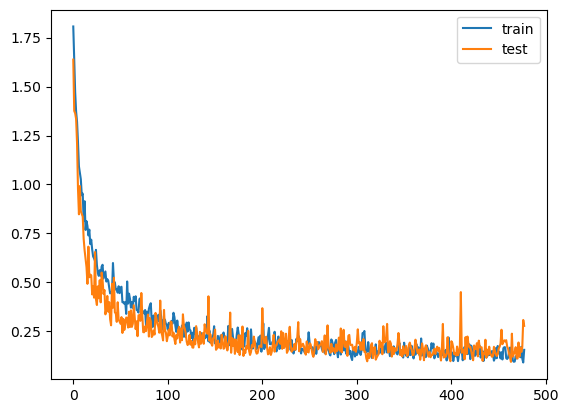

In [27]:
#print("Values stored in history are ... \n", history.history)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

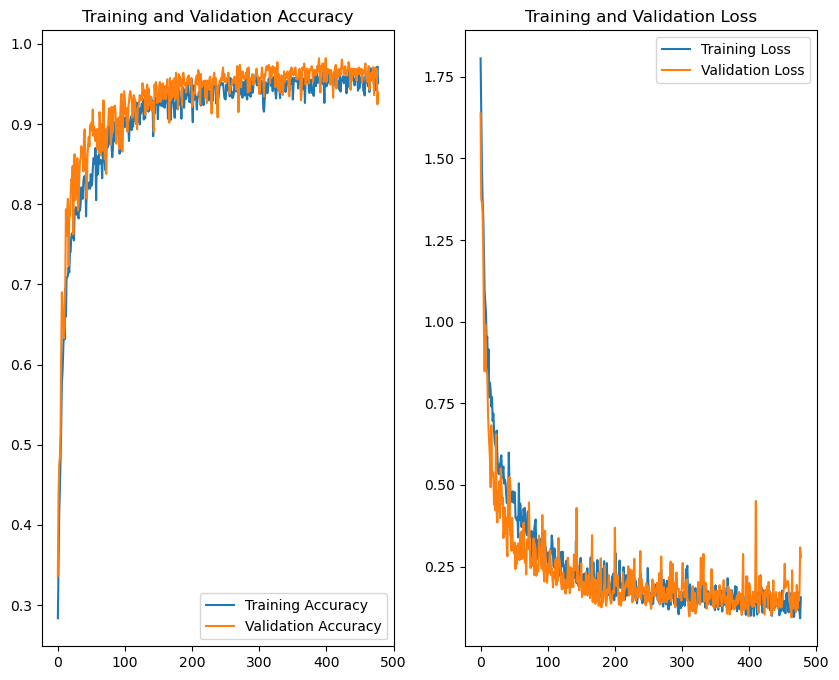

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
# equivalent to: model.save("model.h5")
from tensorflow.keras.models import save_model
save_model(model, "modellistFinal22may.h5")

In [27]:
#For google Colabs
import numpy as np
import keras.utils as image
from google.colab import files
#from keras.preprocessing import image
uploaded=files.upload()

ModuleNotFoundError: No module named 'google.colab'

In [74]:
print(class_names)

['Amoxycillin', 'Cetamol', 'Cetirizine', 'Cipro', 'Jiwanjal', 'SilverSulph', 'Vicks']


0-Amoxycillin 1-Cetamol 2-Cetirizine 3-Cipro 4-Jiwanjal
5-SilverSulph

1/1 [==============================] - 0s 37ms/step


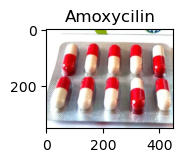

1/1 [==============================] - 0s 46ms/step


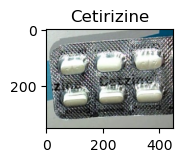

1/1 [==============================] - 0s 53ms/step


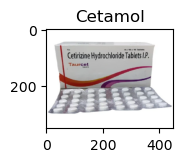

1/1 [==============================] - 0s 45ms/step


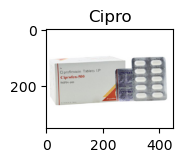

1/1 [==============================] - 0s 29ms/step


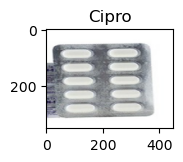

1/1 [==============================] - 0s 38ms/step


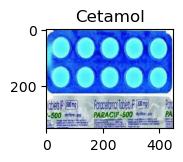

1/1 [==============================] - 0s 46ms/step


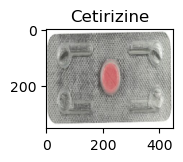

1/1 [==============================] - 0s 35ms/step


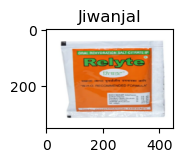

1/1 [==============================] - 0s 27ms/step


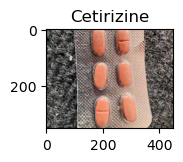

1/1 [==============================] - 0s 27ms/step


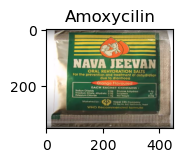

1/1 [==============================] - 0s 29ms/step


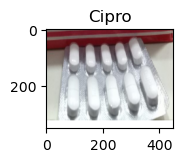

1/1 [==============================] - 0s 29ms/step


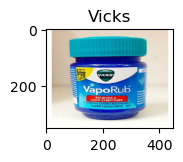

1/1 [==============================] - 0s 31ms/step


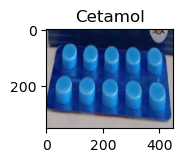

1/1 [==============================] - 0s 29ms/step


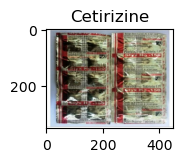

1/1 [==============================] - 0s 28ms/step


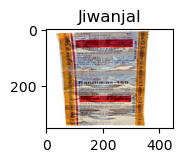

1/1 [==============================] - 0s 27ms/step


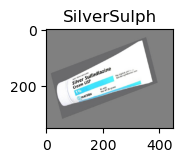

1/1 [==============================] - 0s 27ms/step


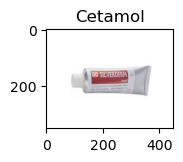

In [31]:
#7typ
dir_path = 'Test image'

for i in os.listdir(dir_path): 
        img = tf.keras.utils.load_img(dir_path+'//'+i,target_size=(350,450))      
        plt.figure(figsize=(2, 2))
        x=tf.keras.utils.img_to_array(img)
        test_img=np.expand_dims(x, axis=0)
        result = model.predict(test_img)
        pred = np.argmax(result) # get the index of max value
        if pred ==0:
                plt.title('Amoxycilin')
        elif pred ==1:
                    plt.title("Cetamol")
        elif pred ==2:
                    plt.title("Cetirizine")
        elif pred ==3:
                    plt.title("Cipro")
        elif pred ==4:
                    plt.title("Jiwanjal")
        elif pred ==5:
                    plt.title("SilverSulph")
        else :
                    plt.title("Vicks")
        plt.tight_layout()
        plt.imshow(img)
        plt.show()

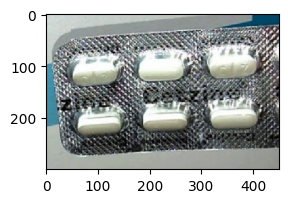

1/1 [==============================] - 0s 16ms/step
SilverSulph


In [30]:

    
    # predicting images
    img = tf.keras.utils.load_img('Test Image\cetri.jpg',target_size=(300,450))
    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.show()
    
    x=tf.keras.utils.img_to_array(img)
    test_img=np.expand_dims(x, axis=0)

    result = model.predict(test_img)
    pred = np.argmax(result) # get the index of max value
    if pred ==0:
        print('\033[1m'+"Amoxycilin")
    elif pred ==1:
          print('\033[1m'+"Cetamol")
    elif pred ==2:
          print('\033[1m'+"Cetirizine")
    elif pred ==3:
          print("Cipro")
    elif pred ==4:
          print('\033[1m'+"Jiwanjal")
    else :
          print('\033[1m'+"SilverSulph")